# Práctica 4: Radiación Natural
Andrés Felipe Pinzón Harker

Instrumentación Nuclear 2024-II.

| material            | archivo                              |
|---------------------|--------------------------------------|
| referencia K        | 2021-11-17_mue_IAEA-RGK-1_24h.csv    |
| referencia U        | 2021-11-17_mue_IAEA-RGU-1_24h.csv    |
| referencia Th       | 2021-11-17_mue_IAEA-RGTh-1_24h.csv   |
| muestra de interés  | 2021-12-04_mue_DG-EG-014_24h.csv     |
| fondo               | 2021-12-15_fon_24h.csv               |


## Previo

Se importan los paquetes y se aplica el formato general


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as wid
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
import colorcet as cc
import os
import copy
from matplotlib.patches import FancyBboxPatch
import uncertainties as un
from uncertainties.umath import *


Se configuran las gráficas, tengase en cuenta que algunos pueden no cargar por dependencias a instalar pendientes.


In [3]:
# Configuración general de las gráficas
%matplotlib widget
mpl.rcParams.update(
    {
        "legend.fontsize": 20,
        "axes.labelsize": 24,  # Updated from 20 to 24
        "axes.titlesize": 24,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "figure.titlesize": 24,
        "axes.titlepad": 10,
        "text.usetex": True,
        "font.family": "Times New Roman",
        "mathtext.fontset": "dejavusans",
        "font.size": 20,
        "axes.labelweight": "bold",
        "axes.grid.which": "both",
        "axes.grid": True,
        "grid.alpha": 0.5,
        "axes.formatter.limits": (-3, 3),  # Use scientific notation for values outside the range 10^-3 to 10^3
        'figure.subplot.bottom': 0.2,
    }
)

colors = cc.glasbey_dark
# Configuracion de colores
k = 3

# Rotar la lista: número positivo para rotar a la derecha, negativo para rotar a la izquierda
colors = colors[-k:] + colors[:-k]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)

# Test
if False:
    plt.figure(figsize=(5, 5))
    plt.plot([1, 2, 3, 4], [1, 4, 9, 16], "o")
    plt.plot([4, 3, 2, 1], [1, 2, 3, 4], "o")
    plt.plot([1, 2, 3, 4], [1, 2, 3, 4], "s")
    plt.plot([4, 3, 2, 1], [1, 4, 9, 16], "s")
    plt.title("Test")
    plt.xlabel("X-axis Label", fontweight="bold")
    plt.ylabel("Y-axis Label")
    plt.show()

## Lectura

In [4]:
# Obtener la lista de archivos en la carpeta actual
archivos = [f for f in os.listdir() if f.startswith('2021') and f.endswith('.csv')]

# Crear un diccionario para almacenar los dataframes
muestras = {}

# Leer cada archivo y guardarlo en el diccionario
for archivo in archivos:
    df = pd.read_csv(archivo)
    muestras[archivo[11:-4]] = df

# Mostrar los nombres de los archivos leídos
print("Archivos leídos:", list(muestras.keys()))

Archivos leídos: ['cal_133Ba22Na137Cs60Co_600s_1', 'mue_IAEA-RGTh-1_24h', 'mue_IAEA-RGU-1_24h', 'mue_IAEA-RGK-1_24h', 'mue_DG-EG-014_24h', 'fon_24h']


In [5]:
# Restar el fondo
fondo = muestras['fon_24h']['I_gamma']
for key in muestras:
    if key != 'fon_24h':
        muestras[key]['I_gamma'] -= fondo

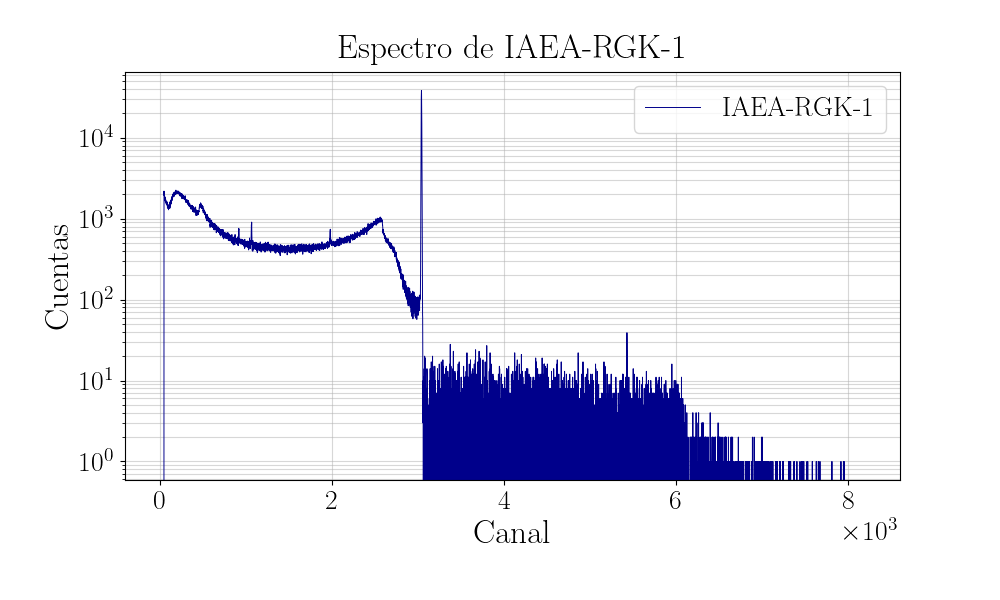

In [6]:
# Graficar espectro individual
nombre ='mue_IAEA-RGK-1_24h'
nombre_split = nombre.split('_')
# plotting
fig, ax = plt.subplots(figsize=(10, 6))
df = muestras[nombre]
ax.plot(df["canal"], df["I_gamma"], label=nombre_split[1], color='darkblue', lw=0.7)
ax.set_xlabel("Canal")
ax.set_ylabel("Cuentas")

ax.set_title(f"Espectro de {nombre_split[1]}")
ax.set_yscale("log")
ax.legend()
plt.show()

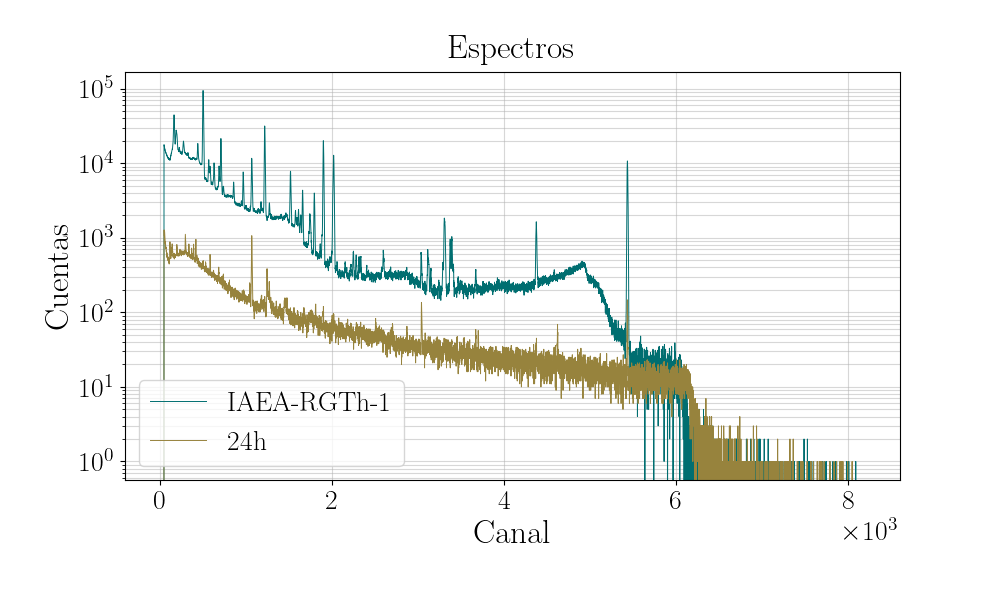

In [7]:
# Graficar varios espectros
archivos =['mue_IAEA-RGTh-1_24h', 'fon_24h']

# plotting
fig, ax = plt.subplots(figsize=(10, 6))
for archivo in archivos:
    archivo_split = archivo.split('_')
    df = muestras[archivo]
    ax.plot(df["canal"], df["I_gamma"], label=archivo_split[1], lw=0.7)

ax.set_xlabel("Canal")
ax.set_ylabel("Cuentas")
ax.set_title(f"Espectros")
ax.set_yscale("log")
ax.legend()
plt.show()

## Calibración

Ya el compañero lo calibró como:

| parametros             |   ajuste       |
|------------------------|----------------|
| $a_0$ (keV)            | -0.96 (13)     |
| $a_1$ (keV/canal)      | 0.48092 (6)    |



In [8]:
# Convertir el canal a energía para cada muestra
def energia(canal):
    '''Se pasa a keV'''
    return -0.96 + 0.48092 * canal

for key, df in muestras.items():
    df["energia"] = df["canal"].apply(energia)

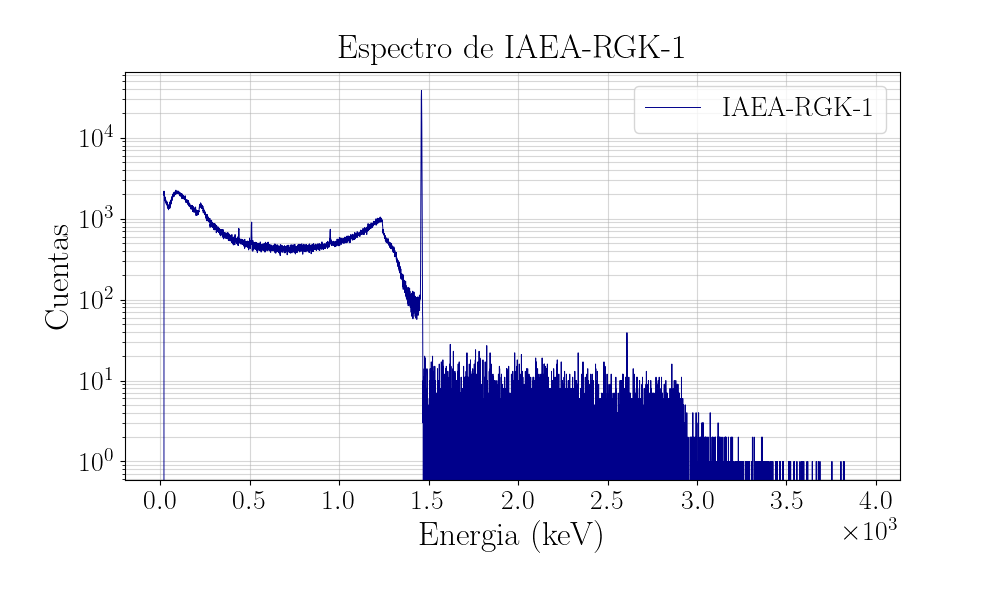

In [9]:
# Graficar espectro individual calibrado para verificar
nombre ='mue_IAEA-RGK-1_24h'
nombre_split = nombre.split('_')
# plotting
fig, ax = plt.subplots(figsize=(10, 6))
df = muestras[nombre]
ax.plot(df["energia"], df["I_gamma"], label=nombre_split[1], color='darkblue', lw=0.7)
ax.set_xlabel("Energia (keV)")
ax.set_ylabel("Cuentas")
ax.set_title(f"Espectro de {nombre_split[1]}")
ax.set_yscale("log")
ax.legend()
plt.show()

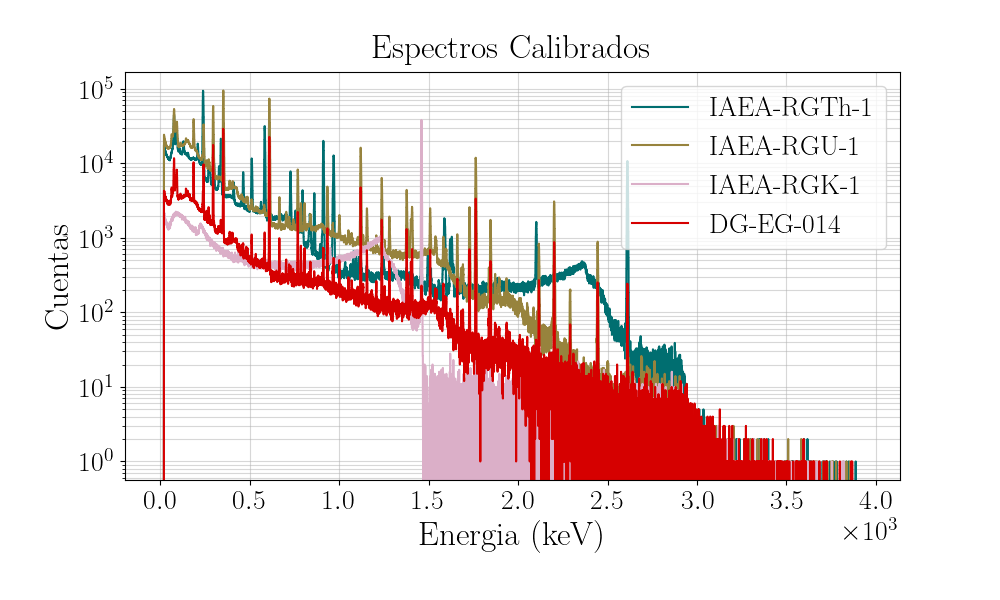

In [10]:
# Graficar varios espectros
archivos =['mue_IAEA-RGTh-1_24h', 'mue_IAEA-RGU-1_24h', 'mue_IAEA-RGK-1_24h', 'mue_DG-EG-014_24h']

# plotting
fig, ax = plt.subplots(figsize=(10, 6))
for archivo in archivos:
    archivo_split = archivo.split('_')
    df = muestras[archivo]
    ax.plot(df["energia"], df["I_gamma"], label=archivo_split[1], lw=1.5, ds="steps-mid")

ax.set_xlabel("Energia (keV)")
ax.set_ylabel("Cuentas")
ax.set_title(f"Espectros Calibrados")
ax.set_yscale("log")
ax.legend()
#ax.set_xlim(1.38e3, 1.49e3)
plt.show()

In [222]:
# Ajuste pico 1461 keV de REFERENCIA sobre un fondo recto
def gaussiana_con_fondo(x, a, x0, sigma, b, m):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b + m * x

# Filtrar los datos en el rango de energía deseado
energia_min = 1450
energia_max = 1470
df = muestras['mue_IAEA-RGK-1_24h']
mask = (df['energia'] >= energia_min) & (df['energia'] <= energia_max)
energia_fit = df['energia'][mask]
I_gamma_fit = df['I_gamma'][mask]

# Ajustar la curva gaussiana con fondo recto
popt, pcov = curve_fit(gaussiana_con_fondo, energia_fit, I_gamma_fit, p0=[max(I_gamma_fit), 1461, 1, min(I_gamma_fit), 0])
# Mejorar la resolución de la gaussiana con linspace
energia_fit_fine = np.linspace(energia_min, energia_max, 1000)
ax.plot(energia_fit_fine, gaussiana_con_fondo(energia_fit_fine, *popt), label='Ajuste Gaussiano con Fondo', color='darkred', lw=3)
# Calcular la intensidad (área bajo la curva de la gaussiana)
intensidad = popt[0] * np.abs(popt[2]) * np.sqrt(2 * np.pi)
incertidumbre_intensidad = intensidad * np.sqrt((pcov[0, 0] / popt[0]**2) + (pcov[2, 2] / popt[2]**2))
print(f"Intensidad ajustada: {intensidad} ± {incertidumbre_intensidad}")
# Imprimir los parámetros ajustados y sus errores
errores = np.sqrt(np.diag(pcov))
print(f"Parámetros ajustados: M = {popt[0]} ± {errores[0]}, mu = {popt[1]} ± {errores[1]}, sigma = {popt[2]} ± {errores[2]}, a0 = {popt[3]} ± {errores[3]}, a1 = {popt[4]} ± {errores[4]}")


Intensidad ajustada: 135811.73735613766 ± 1468.6115041617236
Parámetros ajustados: M = 38077.60083497535 ± 260.000074698601, mu = 1459.568405298938 ± 0.011023810391004456, sigma = 1.4229111871032378 ± 0.011931241011855418, a0 = -13675.185705195761 ± 19194.15987596219, a1 = 9.450396196572786 ± 13.143014883721003


In [225]:
# Ajuste pico 1461 keV para INCOGNITA con fondo
sigma = 1.4229111871032378
def gaussiana_con_fondo_fijo(x, a, x0, b, m):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b + m * x

# Filtrar los datos en el rango de energía deseado
df = muestras['mue_DG-EG-014_24h']
mask = (df['energia'] >= energia_min) & (df['energia'] <= energia_max)
energia_fit = df['energia'][mask]
I_gamma_fit = df['I_gamma'][mask]

# Ajustar la curva gaussiana con sigma fijo y fondo
popt, pcov = curve_fit(gaussiana_con_fondo_fijo, energia_fit, I_gamma_fit, p0=[max(I_gamma_fit), 1461, min(I_gamma_fit), 0])
# Mejorar la resolución de la gaussiana con linspace
energia_fit_fine = np.linspace(energia_min, energia_max, 1000)
ax.plot(energia_fit_fine, gaussiana_con_fondo_fijo(energia_fit_fine, *popt), label='Ajuste', color='darkred', lw=3)
# Calcular la intensidad (área bajo la curva de la gaussiana)
intensidad = popt[0] * np.abs(sigma) * np.sqrt(2 * np.pi)
incertidumbre_intensidad = intensidad * np.sqrt((pcov[0, 0] / popt[0]**2) + (sigma**2 / popt[0]**2))
print(f"Intensidad ajustada: {intensidad} ± {incertidumbre_intensidad}")
# Mostrar los parámetros ajustados
# Calcular los errores de los parámetros ajustados
errores = np.sqrt(np.diag(pcov))

# Imprimir los parámetros ajustados y sus errores
print(f"Parámetros ajustados: a = {popt[0]}, x0 = {popt[1]}, b = {popt[2]}, m = {popt[3]}")
print(f"Errores: Δa = {errores[0]}, Δx0 = {errores[1]}, Δb = {errores[2]}, Δm = {errores[3]}")

Intensidad ajustada: 261.598366916326 ± 28.541846178107907
Parámetros ajustados: a = 73.34445747056866, x0 = 1459.8869859298677, b = -988.1018703685379, m = 0.7576995319493425
Errores: Δa = 7.874768753384085, Δx0 = 0.18940128992450275, Δb = 633.64873125928, Δm = 0.4339602211723614


In [ ]:
# Ajuste pico 1461 keV para INCOGNITA con fondo
sigma = 1.4229111871032378
def gaussiana_con_fondo_fijo(x, a, x0, b, m):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b + m * x

# Filtrar los datos en el rango de energía deseado
df = muestras['mue_IAEA-RGTh-1_24h']
mask = (df['energia'] >= energia_min) & (df['energia'] <= energia_max)
energia_fit = df['energia'][mask]
I_gamma_fit = df['I_gamma'][mask]

# Ajustar la curva gaussiana con sigma fijo y fondo
popt, pcov = curve_fit(gaussiana_con_fondo_fijo, energia_fit, I_gamma_fit, p0=[max(I_gamma_fit), 1461, min(I_gamma_fit), 0])
# Mejorar la resolución de la gaussiana con linspace
energia_fit_fine = np.linspace(energia_min, energia_max, 1000)
ax.plot(energia_fit_fine, gaussiana_con_fondo_fijo(energia_fit_fine, *popt), label='Ajuste', color='darkred', lw=3)
# Calcular la intensidad (área bajo la curva de la gaussiana)
intensidad = popt[0] * np.abs(sigma) * np.sqrt(2 * np.pi)
incertidumbre_intensidad = intensidad * np.sqrt((pcov[0, 0] / popt[0]**2) + (sigma**2 / popt[0]**2))
print(f"Intensidad ajustada: {intensidad} ± {incertidumbre_intensidad}")
# Mostrar los parámetros ajustados
# Calcular los errores de los parámetros ajustados
errores = np.sqrt(np.diag(pcov))

# Imprimir los parámetros ajustados y sus errores
print(f"Parámetros ajustados: a = {popt[0]}, x0 = {popt[1]}, b = {popt[2]}, m = {popt[3]}")
print(f"Errores: Δa = {errores[0]}, Δx0 = {errores[1]}, Δb = {errores[2]}, Δm = {errores[3]}")

Intensidad ajustada: 1436.155364230592 ± 85.3501423653983
Parámetros ajustados: a = 402.6555565869856, x0 = 1458.3497425595476, b = 1140.9048291992056, m = -0.6003594976125397
Errores: Δa = 23.88731745083536, Δx0 = 0.10300451370204977, Δb = 1922.8044018375415, Δm = 1.3163744618282647


In [240]:
# Ajuste pico 1461 keV para INCOGNITA con fondo
sigma = 1.4229111871032378
def gaussiana_con_fondo_fijo(x, a, x0, b, m):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b + m * x

# Filtrar los datos en el rango de energía deseado
df = muestras['mue_IAEA-RGU-1_24h']
mask = (df['energia'] >= energia_min) & (df['energia'] <= energia_max)
energia_fit = df['energia'][mask]
I_gamma_fit = df['I_gamma'][mask]

# Ajustar la curva gaussiana con sigma fijo y fondo
popt, pcov = curve_fit(gaussiana_con_fondo_fijo, energia_fit, I_gamma_fit, p0=[max(I_gamma_fit), 1461, min(I_gamma_fit), 0])
# Mejorar la resolución de la gaussiana con linspace
energia_fit_fine = np.linspace(energia_min, energia_max, 1000)
ax.plot(energia_fit_fine, gaussiana_con_fondo_fijo(energia_fit_fine, *popt), label='Ajuste', color='darkred', lw=3)
# Calcular la intensidad (área bajo la curva de la gaussiana)
intensidad = popt[0] * np.abs(sigma) * np.sqrt(2 * np.pi)
incertidumbre_intensidad = intensidad * np.sqrt((pcov[0, 0] / popt[0]**2) + (sigma**2 / popt[0]**2))
print(f"Intensidad ajustada: {intensidad} ± {incertidumbre_intensidad}")
# Mostrar los parámetros ajustados
# Calcular los errores de los parámetros ajustados
errores = np.sqrt(np.diag(pcov))

# Imprimir los parámetros ajustados y sus errores
print(f"Parámetros ajustados: a = {popt[0]}, x0 = {popt[1]}, b = {popt[2]}, m = {popt[3]}")
print(f"Errores: Δa = {errores[0]}, Δx0 = {errores[1]}, Δb = {errores[2]}, Δm = {errores[3]}")

Intensidad ajustada: 114.12875150116541 ± 57.568521061889086
Parámetros ajustados: a = 31.998331867735835, x0 = 1462.7017635656866, b = -1367.6691518032364, m = 1.3511354720252782
Errores: Δa = 16.07767073698372, Δx0 = 0.8534638463283506, Δb = 1292.8427125742987, Δm = 0.8860029787768872


### Visual de cada pico

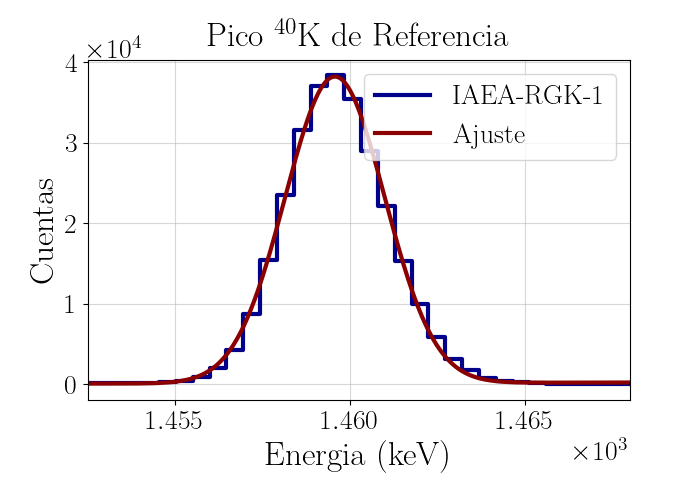

In [224]:
# Ajuste pico referencia
archivos =['mue_IAEA-RGK-1_24h']

# plotting
fig, ax = plt.subplots(figsize=(7, 5))
for archivo in archivos:
    archivo_split = archivo.split('_')
    df = muestras[archivo]
    ax.plot(df["energia"], df["I_gamma"], label=archivo_split[1], lw=3, ds="steps-mid", color='darkblue')
ax.plot(energia_fit_fine, gaussiana_con_fondo(energia_fit_fine, *popt), label='Ajuste', color='darkred', lw=3)
ax.set_xlabel("Energia (keV)")
ax.set_ylabel("Cuentas")
ax.set_title(r"Pico $^{40}$K de Referencia")
#ax.set_yscale("log")
ax.legend()
ax.set_xlim(1.4525e3, 1.468e3)
#ax.set_ylim(0, 3.1e2)
# Guardar la figura en formato PDF
fig.savefig("pico_40K_referencia.pdf", format='pdf')
plt.show()

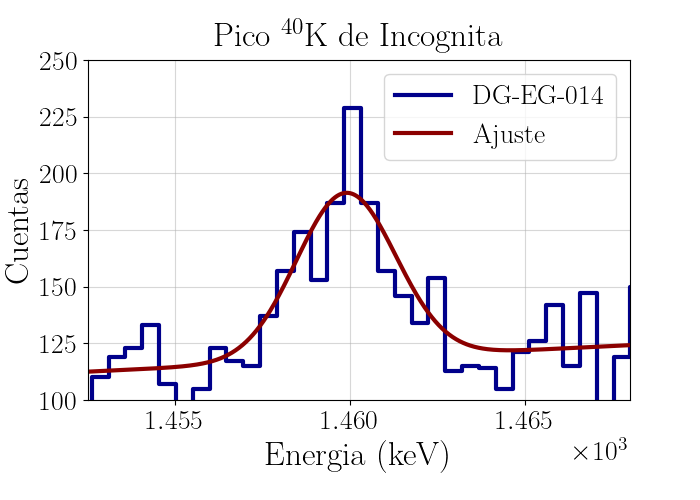

In [227]:
# Ajuste pico muestra incognita
archivos =['mue_DG-EG-014_24h']

# plotting
fig, ax = plt.subplots(figsize=(7,5))
for archivo in archivos:
    archivo_split = archivo.split('_')
    df = muestras[archivo]
    ax.plot(df["energia"], df["I_gamma"], label=archivo_split[1], lw=3, ds="steps-mid", color='darkblue')
ax.plot(energia_fit_fine, gaussiana_con_fondo_fijo(energia_fit_fine, *popt), label='Ajuste', color='darkred', lw=3)
ax.set_xlabel("Energia (keV)")
ax.set_ylabel("Cuentas")
ax.set_title(r"Pico $^{40}$K de Incognita")
#ax.set_yscale("log")
ax.legend()
ax.set_xlim(1.4525e3, 1.468e3)
ax.set_ylim(100, 250)
fig.savefig('pico_40K_incognita.pdf')
plt.show()

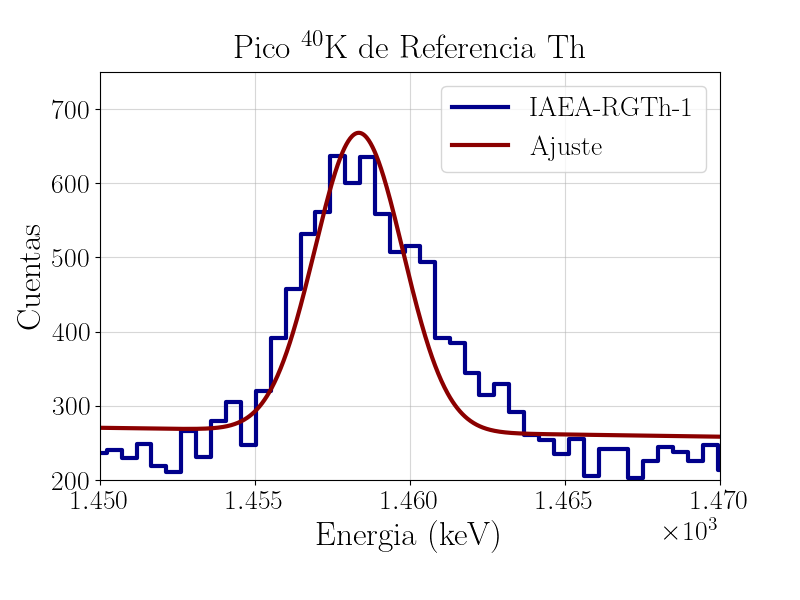

In [ ]:
# Ajuste pico muestra incognita
archivos =['mue_IAEA-RGTh-1_24h']

# plotting
fig, ax = plt.subplots(figsize=(8,6))
for archivo in archivos:
    archivo_split = archivo.split('_')
    df = muestras[archivo]
    ax.plot(df["energia"], df["I_gamma"], label=archivo_split[1], lw=3, ds="steps-mid", color='darkblue')
ax.plot(energia_fit_fine, gaussiana_con_fondo_fijo(energia_fit_fine, *popt), label='Ajuste', color='darkred', lw=3)
ax.set_xlabel("Energia (keV)")
ax.set_ylabel("Cuentas")
ax.set_title(r"Pico $^{40}$K de Referencia Th")
#ax.set_yscale("log")
ax.legend()
ax.set_xlim(1.45e3, 1.47e3)
ax.set_ylim(200, 0.75e3)
fig.savefig('pico_40K_.pdf')
plt.show()

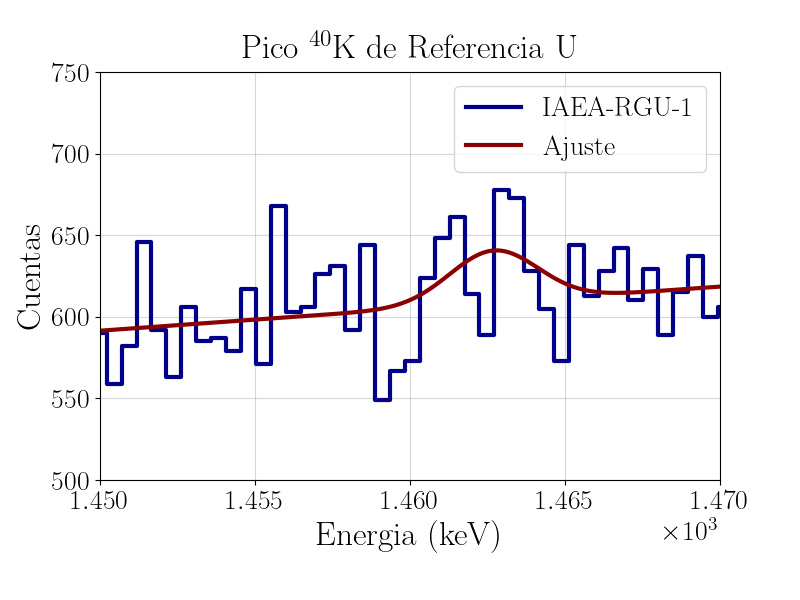

In [244]:
# Ajuste pico muestra incognita
archivos =['mue_IAEA-RGU-1_24h']

# plotting
fig, ax = plt.subplots(figsize=(8,6))
for archivo in archivos:
    archivo_split = archivo.split('_')
    df = muestras[archivo]
    ax.plot(df["energia"], df["I_gamma"], label=archivo_split[1], lw=3, ds="steps-mid", color='darkblue')
ax.plot(energia_fit_fine, gaussiana_con_fondo_fijo(energia_fit_fine, *popt), label='Ajuste', color='darkred', lw=3)
ax.set_xlabel("Energia (keV)")
ax.set_ylabel("Cuentas")
ax.set_title(r"Pico $^{40}$K de Referencia U")
#ax.set_yscale("log")
ax.legend()
ax.set_xlim(1.45e3, 1.47e3)
ax.set_ylim(500, 0.75e3)
fig.savefig('pico_40K_U.pdf')
plt.show()

### Incertidumbres Intensidads $I_i$

In [ ]:
a = un.ufloat(38077.60083497535, 260.000074698601)
sigma = un.ufloat(1.4229111871032378, 0.011931241011855418)
I_r = np.sqrt(2 * np.pi) * a * sigma

a = un.ufloat(73.34445747056866, 7.874768753384085)
sigma = un.ufloat(1.4229111871032378, 0.011931241011855418)
I_m = np.sqrt(2 * np.pi) * a * sigma
cr = 0.448

cm = I_m/I_r * cr
print(f"Intensidad de referencia (I_r): {I_r}")
print(f"Intensidad de muestra (I_m): {I_m}")
print(f"concetración (c_m): {cm * 100:.2f}  %")


Intensidad de referencia (I_r): (1.358+/-0.015)e+05
Intensidad de muestra (I_m): 262+/-28
Coeficiente de correlación (c_m): 0.09+/-0.01%


In [55]:
# referencia
a = un.ufloat(10621.754854139832, 95.11342281908992)
sigma = un.ufloat(2.227383659605065, 0.02517631567146677)
I_r = np.sqrt(2 * np.pi) * a * sigma

a = un.ufloat(178.74077895602457, 12.855230101979526)
I_m = np.sqrt(2 * np.pi) * a * sigma
cr = un.ufloat(800, 16)*1e-6

cm = I_m/I_r * cr
print(f"Intensidad de referencia (I_r): {I_r}")
print(f"Intensidad de muestra (I_m): {I_m}")
print(f"concetración (c_m): {cm * 100:.5f}  %")

Intensidad de referencia (I_r): (5.93+/-0.09)e+04
Intensidad de muestra (I_m): (1.00+/-0.07)e+03
concetración (c_m): 0.00135+/-0.00010  %


In [56]:
from uncertainties import ufloat

# Definir valores con sus incertidumbres
valor = un.ufloat(800.0, 1.6) * 1e-6

# Formatear el valor en notación científica
valor_formateado = "{:.2e}".format(valor.nominal_value)
incertidumbre_formateada = "{:.2e}".format(valor.std_dev)

# Imprimir el resultado formateado
print(f"Valor: {valor_formateado} ± {incertidumbre_formateada}")

Valor: 8.00e-04 ± 1.60e-06


In [ ]:
from uncertainties import ufloat

# Definir valores con sus incertidumbres
ir = ufloat(135923.25, 978.03)
im = ufloat(276.40, 1.92)
cr = ufloat(0.44800, 0.003)

# Calcular la expresión con incertidumbre
resultado = (im * cr)*100 / ir 
resultado2 = cr*100*0.000117*10**4
resultado3 = resultado*100*0.000117*10**4

# Imprimir resultado
print(f"Resultado: {resultado:.6f} %")
print(f"Resultado2: {resultado2:.6f}")
print(f"Resultado3: {resultado3:.6f}")

Resultado: 0.091101+/-0.001097 %
Resultado2: 52.416000+/-0.351000
Resultado3: 10.658796+/-0.128291


0.000117

### Visuales de Pico U (353 keV)

### Visuales de Pico U (2614.5 keV)

In [23]:
# Ajuste pico 353 keV de REFERENCIA sobre un fondo recto
def gaussiana_con_fondo(x, a, x0, sigma, b, m):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b + m * x

# Filtrar los datos en el rango de energía deseado
energia_min = 2.60e3
energia_max = 2.625e3
df = muestras['mue_IAEA-RGTh-1_24h']
mask = (df['energia'] >= energia_min) & (df['energia'] <= energia_max)
energia_fit = df['energia'][mask]
I_gamma_fit = df['I_gamma'][mask]

# Ajustar la curva gaussiana con fondo recto
popt, pcov = curve_fit(gaussiana_con_fondo, energia_fit, I_gamma_fit, p0=[max(I_gamma_fit), 2611, 1, min(I_gamma_fit), 0])
# Mejorar la resolución de la gaussiana con linspace
energia_fit_fine = np.linspace(energia_min, energia_max, 1000)
ax.plot(energia_fit_fine, gaussiana_con_fondo(energia_fit_fine, *popt), label='Ajuste Gaussiano con Fondo', color='darkred', lw=3)
# Calcular la intensidad (área bajo la curva de la gaussiana)
intensidad = popt[0] * np.abs(popt[2]) * np.sqrt(2 * np.pi)
incertidumbre_intensidad = intensidad * np.sqrt((pcov[0, 0] / popt[0]**2) + (pcov[2, 2] / popt[2]**2))
print(f"Intensidad ajustada: {intensidad} ± {incertidumbre_intensidad}")
# Imprimir los parámetros ajustados y sus errores
errores = np.sqrt(np.diag(pcov))
print(f"Parámetros ajustados: M = {popt[0]} ± {errores[0]}, mu = {popt[1]} ± {errores[1]}, sigma = {popt[2]} ± {errores[2]}, a0 = {popt[3]} ± {errores[3]}, a1 = {popt[4]} ± {errores[4]}")


Intensidad ajustada: 59303.624510882684 ± 855.1747978088225
Parámetros ajustados: M = 10621.754854139832 ± 95.11342281908992, mu = 2611.184079486229 ± 0.022594263514270685, sigma = 2.227383659605065 ± 0.02517631567146677, a0 = -13159.984857486514 ± 11157.36163405098, a1 = 5.058661358553452 ± 4.268488577116039


In [36]:
# Ajuste pico 1461 keV para INCOGNITA con fondo
sigma = 2.227383659605065 
def gaussiana_con_fondo_fijo(x, a, x0, b, m):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b + m * x

# Filtrar los datos en el rango de energía deseado
df = muestras['mue_DG-EG-014_24h']
mask = (df['energia'] >= energia_min) & (df['energia'] <= energia_max)
energia_fit = df['energia'][mask]
I_gamma_fit = df['I_gamma'][mask]

# Ajustar la curva gaussiana con sigma fijo y fondo
popt, pcov = curve_fit(gaussiana_con_fondo_fijo, energia_fit, I_gamma_fit, p0=[max(I_gamma_fit), 2611, min(I_gamma_fit), 0])
# Mejorar la resolución de la gaussiana con linspace
energia_fit_fine = np.linspace(energia_min, energia_max, 1000)
ax.plot(energia_fit_fine, gaussiana_con_fondo_fijo(energia_fit_fine, *popt), label='Ajuste', color='darkred', lw=3)
# Calcular la intensidad (área bajo la curva de la gaussiana)
intensidad = popt[0] * np.abs(sigma) * np.sqrt(2 * np.pi)
incertidumbre_intensidad = intensidad * np.sqrt((pcov[0, 0] / popt[0]**2) + (sigma**2 / popt[0]**2))
print(f"Intensidad ajustada: {intensidad} ± {incertidumbre_intensidad}")
# Mostrar los parámetros ajustados
# Calcular los errores de los parámetros ajustados
errores = np.sqrt(np.diag(pcov))

# Imprimir los parámetros ajustados y sus errores
print(f"Parámetros ajustados: a = {popt[0]}, x0 = {popt[1]}, b = {popt[2]}, m = {popt[3]}")
print(f"Errores: Δa = {errores[0]}, Δx0 = {errores[1]}, Δb = {errores[2]}, Δm = {errores[3]}")

Intensidad ajustada: 997.9496030130483 ± 72.84301841196387
Parámetros ajustados: a = 178.74077895602457, x0 = 2611.140971647283, b = -685.1120550236787, m = 0.25888406653255513
Errores: Δa = 12.855230101979526, Δx0 = 0.19147606545905724, Δb = 1577.9296266068864, Δm = 0.6038104863679642


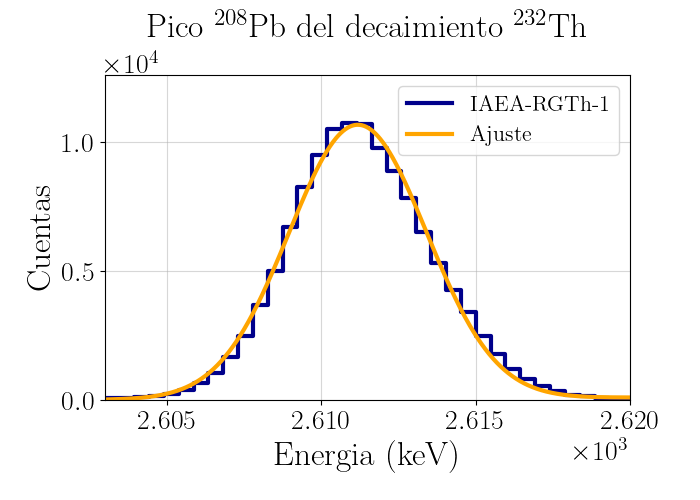

In [35]:
# Ajuste pico referencia
archivos =['mue_IAEA-RGTh-1_24h']

# plotting
fig, ax = plt.subplots(figsize=(7, 5))
for archivo in archivos:
    archivo_split = archivo.split('_')
    df = muestras[archivo]
    ax.plot(df["energia"], df["I_gamma"], label=archivo_split[1], lw=3, ds="steps-mid", color='darkblue')
ax.plot(energia_fit_fine, gaussiana_con_fondo(energia_fit_fine, *popt), label='Ajuste', color='#FFA500', lw=3)
ax.set_xlabel("Energia (keV)")
ax.set_ylabel("Cuentas")
ax.set_title(r"Pico $^{208}$Pb del decaimiento $^{232}$Th")
#ax.set_yscale("log")
ax.legend(fontsize=16)
ax.set_xlim(2.603e3, 2.62e3)
ax.set_ylim(0, 1.26e4)
# Guardar la figura en formato PDF
plt.subplots_adjust(left=0.15)
plt.subplots_adjust(top=0.85)
fig.savefig("pico_Th_referencia.pdf", format='pdf')
plt.show()

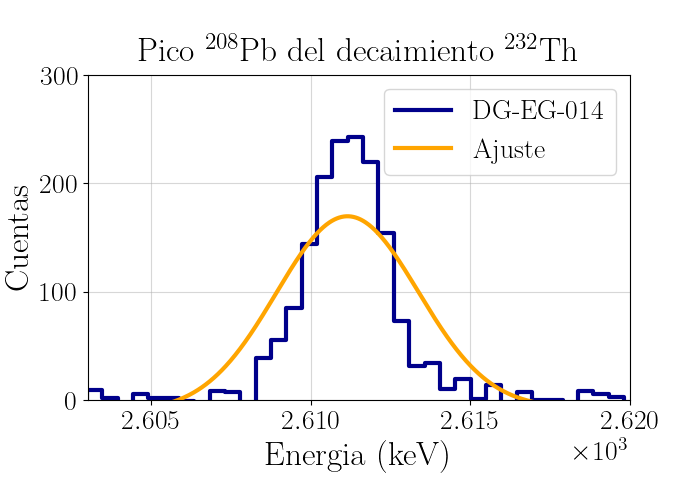

In [39]:
# Ajuste pico referencia
archivos =['mue_DG-EG-014_24h']

# plotting
fig, ax = plt.subplots(figsize=(7, 5))
for archivo in archivos:
    archivo_split = archivo.split('_')
    df = muestras[archivo]
    ax.plot(df["energia"], df["I_gamma"], label=archivo_split[1], lw=3, ds="steps-mid", color='darkblue')
ax.plot(energia_fit_fine, gaussiana_con_fondo_fijo(energia_fit_fine, *popt), label='Ajuste', color='#FFA500', lw=3)
ax.set_xlabel("Energia (keV)")
ax.set_ylabel("Cuentas")
ax.set_title(r"Pico $^{208}$Pb del decaimiento $^{232}$Th")
#ax.set_yscale("log")
ax.legend()
ax.set_xlim(2.603e3, 2.62e3)
ax.set_ylim(0, 3e2)
# Guardar la figura en formato PDF
plt.subplots_adjust(top=0.85)
fig.savefig("pico_Th_muestra.pdf", format='pdf')
plt.show()